# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

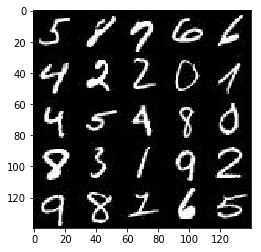

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

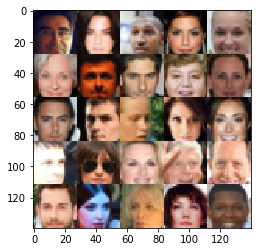

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    inputs_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/kanamori-kazuki/.pyenv/versions/anac

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(conv1 * 0.2, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, axis=1, training=True)
        conv2 = tf.maximum(conv2 * 0.2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, axis=1, training=True)
        conv3 = tf.maximum(conv3 * 0.2, conv3)
        
        conv3_shape = conv3.shape.as_list()
        
        flat = tf.reshape(conv3, [-1, conv3_shape[1] * conv3_shape[2] * conv3_shape[3]])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, [-1, 7, 7, 512])
        x = tf.layers.batch_normalization(x, axis=1, training=is_train)
        x = tf.maximum(x * 0.2, x)
        
        trconv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        trconv1 = tf.layers.batch_normalization(trconv1, axis=1, training=is_train)
        trconv1 = tf.maximum(trconv1 * 0.2, trconv1)
        
        trconv2 = tf.layers.conv2d_transpose(trconv1, 128, 5, strides=2, padding='same')
        trconv2 = tf.layers.batch_normalization(trconv2, axis=1, training=is_train)
        trconv2 = tf.maximum(trconv2 * 0.2, trconv2)
        
        trconv3 = tf.layers.conv2d_transpose(trconv2, out_channel_dim, 5, strides=1, padding='same')
#         trconv3 = tf.layers.batch_normalization(trconv3, axis=1, training=is_train)
#         trconv3 = tf.maximum(trconv3 * 0.2, trconv3)
        
#         trconv4 = tf.layers.conv2d_transpose(trconv3, out_channel_dim, 5, strides=1, padding='same')

        out = tf.tanh(trconv3)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_out = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake))
    )
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake))
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # TODO: Build Model
#     tf.reset_default_graph()
    
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learn_rate: learning_rate})
                
                if steps % 5 == 0:
                    d_train_loss = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    g_train_loss = g_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    print('Epoch: {}/{}'.format(epoch_i + 1, epoch_count), 
                          'Discriminator Loss: {:.4f}'.format(d_train_loss),
                          'Generator Loss: {:.4f}'.format(g_train_loss))
                if steps % 25 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

ResourceExhaustedError: OOM when allocating tensor with shape[128,256,14,14]
	 [[Node: generator/conv2d_transpose/conv2d_transpose_2 = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](generator/conv2d_transpose/stack, generator/conv2d_transpose/kernel/read, generator/Maximum)]]

Caused by op 'generator/conv2d_transpose/conv2d_transpose_2', defined at:
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-344a5c731f86>", line 15, in <module>
    mnist_dataset.shape, mnist_dataset.image_mode)
  File "<ipython-input-12-d9e13fe25dd6>", line 18, in train
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
  File "<ipython-input-9-f9e01db1296d>", line 11, in model_loss
    g_out = generator(input_z, out_channel_dim)
  File "<ipython-input-8-baee01e7fc78>", line 16, in generator
    trconv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 1282, in conv2d_transpose
    return layer.apply(inputs)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 492, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 1162, in call
    data_format=utils.convert_data_format(self.data_format, ndim=4))
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1046, in conv2d_transpose
    name=name)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 488, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/kanamori-kazuki/.pyenv/versions/anaconda3-4.3.1/envs/dlnd/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,256,14,14]
	 [[Node: generator/conv2d_transpose/conv2d_transpose_2 = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](generator/conv2d_transpose/stack, generator/conv2d_transpose/kernel/read, generator/Maximum)]]


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/10 Discriminator Loss: 0.9522 Generator Loss: 0.8145
Epoch: 1/10 Discriminator Loss: 1.1909 Generator Loss: 0.4988
Epoch: 1/10 Discriminator Loss: 0.1923 Generator Loss: 6.5689
Epoch: 1/10 Discriminator Loss: 0.2553 Generator Loss: 7.4900
Epoch: 1/10 Discriminator Loss: 0.1291 Generator Loss: 2.6576


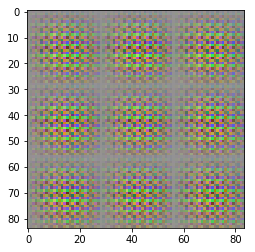

Epoch: 1/10 Discriminator Loss: 0.1487 Generator Loss: 3.1732
Epoch: 1/10 Discriminator Loss: 0.1099 Generator Loss: 2.8571
Epoch: 1/10 Discriminator Loss: 0.7221 Generator Loss: 8.4472
Epoch: 1/10 Discriminator Loss: 0.1396 Generator Loss: 2.3454
Epoch: 1/10 Discriminator Loss: 0.2537 Generator Loss: 1.5519


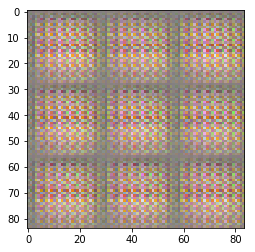

Epoch: 1/10 Discriminator Loss: 0.1985 Generator Loss: 2.8745
Epoch: 1/10 Discriminator Loss: 0.3309 Generator Loss: 3.6585
Epoch: 1/10 Discriminator Loss: 0.2960 Generator Loss: 2.1935
Epoch: 1/10 Discriminator Loss: 3.6147 Generator Loss: 0.0306
Epoch: 1/10 Discriminator Loss: 1.6866 Generator Loss: 0.2273


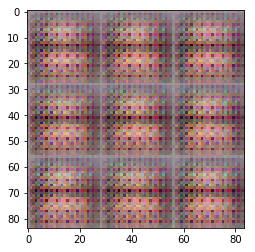

Epoch: 1/10 Discriminator Loss: 0.7201 Generator Loss: 7.6592
Epoch: 1/10 Discriminator Loss: 1.9008 Generator Loss: 0.2188
Epoch: 1/10 Discriminator Loss: 0.5387 Generator Loss: 2.3621
Epoch: 1/10 Discriminator Loss: 0.7062 Generator Loss: 4.1489
Epoch: 1/10 Discriminator Loss: 1.4450 Generator Loss: 0.4980


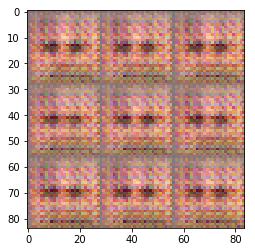

Epoch: 1/10 Discriminator Loss: 0.5749 Generator Loss: 2.1117
Epoch: 1/10 Discriminator Loss: 1.1605 Generator Loss: 4.3732
Epoch: 1/10 Discriminator Loss: 1.6610 Generator Loss: 0.5836
Epoch: 1/10 Discriminator Loss: 0.8808 Generator Loss: 1.2814
Epoch: 1/10 Discriminator Loss: 1.0433 Generator Loss: 1.1434


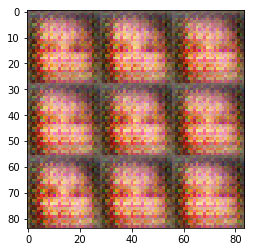

Epoch: 1/10 Discriminator Loss: 0.7078 Generator Loss: 2.0095
Epoch: 1/10 Discriminator Loss: 0.3526 Generator Loss: 3.1213
Epoch: 1/10 Discriminator Loss: 0.1181 Generator Loss: 3.1797
Epoch: 1/10 Discriminator Loss: 0.5630 Generator Loss: 1.3005
Epoch: 1/10 Discriminator Loss: 1.1722 Generator Loss: 1.1205


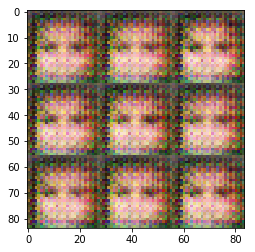

Epoch: 1/10 Discriminator Loss: 0.9320 Generator Loss: 1.1589
Epoch: 1/10 Discriminator Loss: 0.6590 Generator Loss: 1.2458
Epoch: 1/10 Discriminator Loss: 0.4849 Generator Loss: 1.9524
Epoch: 1/10 Discriminator Loss: 0.8956 Generator Loss: 0.9938
Epoch: 1/10 Discriminator Loss: 0.5118 Generator Loss: 3.3110


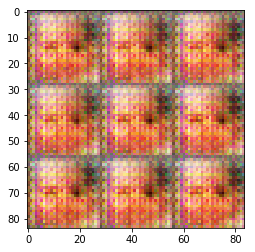

Epoch: 1/10 Discriminator Loss: 0.1008 Generator Loss: 4.2490
Epoch: 1/10 Discriminator Loss: 0.2377 Generator Loss: 3.8972
Epoch: 1/10 Discriminator Loss: 0.4841 Generator Loss: 1.8812
Epoch: 1/10 Discriminator Loss: 2.1969 Generator Loss: 0.4003
Epoch: 1/10 Discriminator Loss: 0.2192 Generator Loss: 5.3339


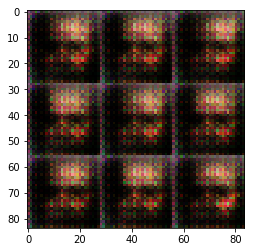

Epoch: 1/10 Discriminator Loss: 1.1548 Generator Loss: 0.7990
Epoch: 1/10 Discriminator Loss: 0.7820 Generator Loss: 1.5394
Epoch: 1/10 Discriminator Loss: 0.2147 Generator Loss: 2.4904
Epoch: 1/10 Discriminator Loss: 0.1535 Generator Loss: 2.4905
Epoch: 1/10 Discriminator Loss: 0.2477 Generator Loss: 2.3112


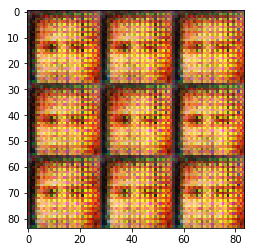

Epoch: 1/10 Discriminator Loss: 1.0717 Generator Loss: 0.8118
Epoch: 1/10 Discriminator Loss: 0.2143 Generator Loss: 2.8279
Epoch: 1/10 Discriminator Loss: 0.4232 Generator Loss: 1.7669
Epoch: 1/10 Discriminator Loss: 0.6790 Generator Loss: 1.5188
Epoch: 1/10 Discriminator Loss: 0.5142 Generator Loss: 1.8209


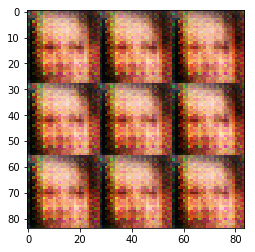

Epoch: 1/10 Discriminator Loss: 0.4268 Generator Loss: 2.5016
Epoch: 1/10 Discriminator Loss: 0.2743 Generator Loss: 3.0481
Epoch: 1/10 Discriminator Loss: 0.3244 Generator Loss: 2.2770
Epoch: 1/10 Discriminator Loss: 0.4197 Generator Loss: 2.0366
Epoch: 1/10 Discriminator Loss: 0.6844 Generator Loss: 1.8766


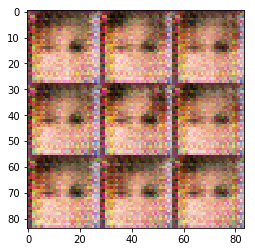

Epoch: 1/10 Discriminator Loss: 0.7769 Generator Loss: 4.8074
Epoch: 1/10 Discriminator Loss: 0.4693 Generator Loss: 1.4578
Epoch: 1/10 Discriminator Loss: 0.3955 Generator Loss: 4.1333
Epoch: 1/10 Discriminator Loss: 0.0777 Generator Loss: 3.7228
Epoch: 1/10 Discriminator Loss: 0.0551 Generator Loss: 3.7030


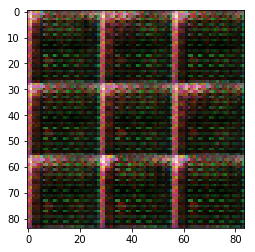

Epoch: 1/10 Discriminator Loss: 0.1441 Generator Loss: 3.0041
Epoch: 1/10 Discriminator Loss: 0.1255 Generator Loss: 2.5251
Epoch: 1/10 Discriminator Loss: 1.5925 Generator Loss: 0.4672
Epoch: 1/10 Discriminator Loss: 0.3808 Generator Loss: 2.3760
Epoch: 1/10 Discriminator Loss: 1.2906 Generator Loss: 1.1586


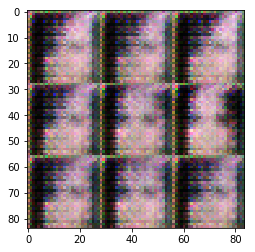

Epoch: 1/10 Discriminator Loss: 0.3104 Generator Loss: 2.8107
Epoch: 1/10 Discriminator Loss: 0.4789 Generator Loss: 2.0391
Epoch: 1/10 Discriminator Loss: 0.8185 Generator Loss: 1.7778
Epoch: 1/10 Discriminator Loss: 0.8244 Generator Loss: 1.4492
Epoch: 1/10 Discriminator Loss: 1.0132 Generator Loss: 1.1566


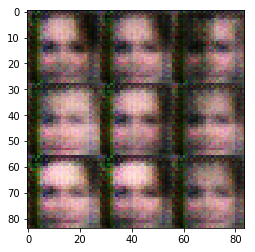

Epoch: 1/10 Discriminator Loss: 0.6222 Generator Loss: 1.7450
Epoch: 1/10 Discriminator Loss: 1.1173 Generator Loss: 1.2053
Epoch: 1/10 Discriminator Loss: 1.4631 Generator Loss: 0.8037
Epoch: 1/10 Discriminator Loss: 1.1429 Generator Loss: 0.9097
Epoch: 1/10 Discriminator Loss: 1.0009 Generator Loss: 1.0545


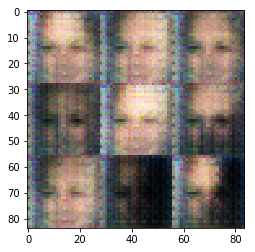

Epoch: 1/10 Discriminator Loss: 0.9230 Generator Loss: 1.1990
Epoch: 1/10 Discriminator Loss: 0.8845 Generator Loss: 1.0905
Epoch: 1/10 Discriminator Loss: 0.9565 Generator Loss: 1.0365
Epoch: 1/10 Discriminator Loss: 0.8328 Generator Loss: 1.1652
Epoch: 1/10 Discriminator Loss: 0.8249 Generator Loss: 1.1150


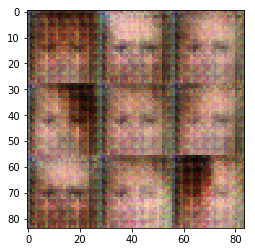

Epoch: 1/10 Discriminator Loss: 1.1307 Generator Loss: 0.9468
Epoch: 1/10 Discriminator Loss: 0.8060 Generator Loss: 1.2851
Epoch: 1/10 Discriminator Loss: 1.1227 Generator Loss: 0.9633
Epoch: 1/10 Discriminator Loss: 0.8357 Generator Loss: 1.1196
Epoch: 1/10 Discriminator Loss: 0.9057 Generator Loss: 1.2718


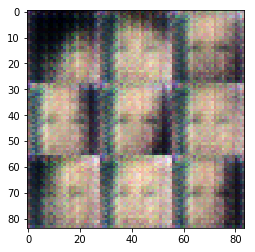

Epoch: 1/10 Discriminator Loss: 0.8136 Generator Loss: 1.3531
Epoch: 1/10 Discriminator Loss: 0.8429 Generator Loss: 1.2082
Epoch: 1/10 Discriminator Loss: 0.8238 Generator Loss: 1.0880
Epoch: 1/10 Discriminator Loss: 0.8787 Generator Loss: 1.0487
Epoch: 1/10 Discriminator Loss: 0.7883 Generator Loss: 1.1995


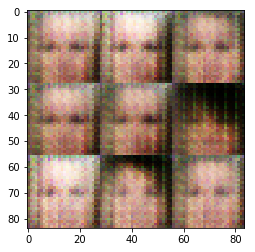

Epoch: 1/10 Discriminator Loss: 0.8111 Generator Loss: 1.2431
Epoch: 1/10 Discriminator Loss: 0.6834 Generator Loss: 1.8277
Epoch: 1/10 Discriminator Loss: 1.1919 Generator Loss: 0.5421
Epoch: 1/10 Discriminator Loss: 0.7283 Generator Loss: 1.4857
Epoch: 1/10 Discriminator Loss: 0.8268 Generator Loss: 2.3315


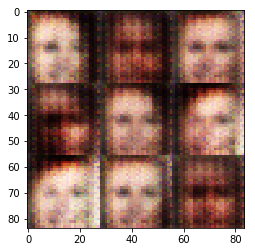

Epoch: 1/10 Discriminator Loss: 0.7552 Generator Loss: 1.4715
Epoch: 1/10 Discriminator Loss: 0.9334 Generator Loss: 1.0216
Epoch: 1/10 Discriminator Loss: 1.2631 Generator Loss: 1.0763
Epoch: 1/10 Discriminator Loss: 0.6607 Generator Loss: 2.6252
Epoch: 1/10 Discriminator Loss: 1.1067 Generator Loss: 1.2659


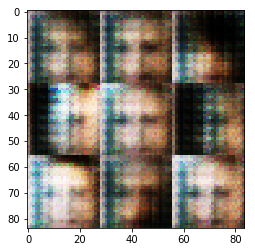

Epoch: 1/10 Discriminator Loss: 0.6275 Generator Loss: 1.6702
Epoch: 1/10 Discriminator Loss: 1.1369 Generator Loss: 1.2201
Epoch: 1/10 Discriminator Loss: 0.6714 Generator Loss: 1.6856
Epoch: 1/10 Discriminator Loss: 0.9147 Generator Loss: 1.1808
Epoch: 1/10 Discriminator Loss: 0.8536 Generator Loss: 1.5295


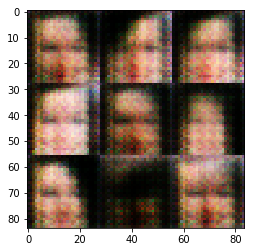

Epoch: 1/10 Discriminator Loss: 1.1801 Generator Loss: 0.9431
Epoch: 1/10 Discriminator Loss: 0.8676 Generator Loss: 1.5427
Epoch: 1/10 Discriminator Loss: 1.2270 Generator Loss: 0.8788
Epoch: 1/10 Discriminator Loss: 1.2007 Generator Loss: 0.8333
Epoch: 1/10 Discriminator Loss: 0.9772 Generator Loss: 0.9755


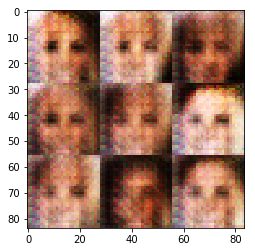

Epoch: 1/10 Discriminator Loss: 1.1145 Generator Loss: 1.3854
Epoch: 1/10 Discriminator Loss: 0.7037 Generator Loss: 1.8183
Epoch: 1/10 Discriminator Loss: 1.2073 Generator Loss: 1.3811
Epoch: 1/10 Discriminator Loss: 1.1582 Generator Loss: 0.8877
Epoch: 1/10 Discriminator Loss: 1.1409 Generator Loss: 0.7051


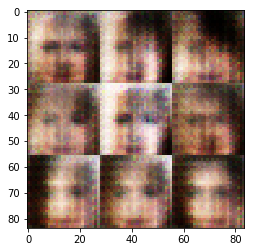

Epoch: 1/10 Discriminator Loss: 0.9404 Generator Loss: 2.3378
Epoch: 1/10 Discriminator Loss: 1.1115 Generator Loss: 1.2342
Epoch: 1/10 Discriminator Loss: 0.7828 Generator Loss: 1.7842
Epoch: 1/10 Discriminator Loss: 1.1362 Generator Loss: 2.5521
Epoch: 1/10 Discriminator Loss: 0.9114 Generator Loss: 2.3464


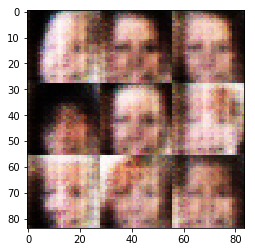

Epoch: 1/10 Discriminator Loss: 0.8472 Generator Loss: 1.0759
Epoch: 1/10 Discriminator Loss: 0.8842 Generator Loss: 1.8004
Epoch: 1/10 Discriminator Loss: 0.8050 Generator Loss: 1.4451
Epoch: 1/10 Discriminator Loss: 1.3232 Generator Loss: 0.7716
Epoch: 1/10 Discriminator Loss: 1.5728 Generator Loss: 0.5194


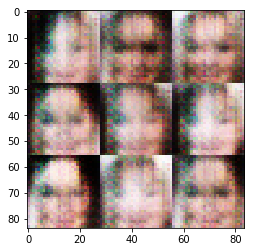

Epoch: 1/10 Discriminator Loss: 0.6503 Generator Loss: 1.4656
Epoch: 1/10 Discriminator Loss: 0.7939 Generator Loss: 1.4726
Epoch: 1/10 Discriminator Loss: 1.0825 Generator Loss: 1.5549
Epoch: 1/10 Discriminator Loss: 1.3357 Generator Loss: 0.9613
Epoch: 1/10 Discriminator Loss: 0.7779 Generator Loss: 1.1755


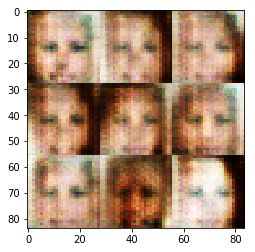

Epoch: 1/10 Discriminator Loss: 0.6317 Generator Loss: 1.5348
Epoch: 1/10 Discriminator Loss: 0.8979 Generator Loss: 1.4512
Epoch: 1/10 Discriminator Loss: 1.2150 Generator Loss: 0.6538
Epoch: 1/10 Discriminator Loss: 1.0555 Generator Loss: 1.3227
Epoch: 1/10 Discriminator Loss: 0.7208 Generator Loss: 1.7461


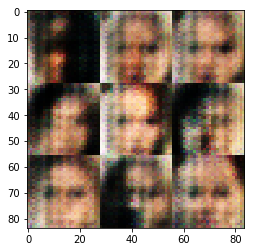

Epoch: 1/10 Discriminator Loss: 1.1871 Generator Loss: 0.8853
Epoch: 1/10 Discriminator Loss: 1.0629 Generator Loss: 1.1082
Epoch: 1/10 Discriminator Loss: 0.7930 Generator Loss: 1.4479
Epoch: 1/10 Discriminator Loss: 0.7574 Generator Loss: 1.9106
Epoch: 1/10 Discriminator Loss: 0.8943 Generator Loss: 1.2914


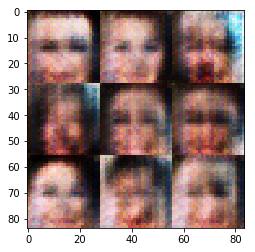

Epoch: 1/10 Discriminator Loss: 1.2711 Generator Loss: 1.5109
Epoch: 1/10 Discriminator Loss: 1.0528 Generator Loss: 1.7535
Epoch: 1/10 Discriminator Loss: 0.7563 Generator Loss: 1.4923
Epoch: 1/10 Discriminator Loss: 0.8131 Generator Loss: 1.4796
Epoch: 1/10 Discriminator Loss: 0.7181 Generator Loss: 1.7490


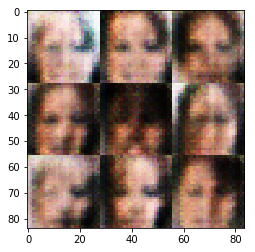

Epoch: 1/10 Discriminator Loss: 1.1143 Generator Loss: 0.9090
Epoch: 1/10 Discriminator Loss: 1.2104 Generator Loss: 2.9039
Epoch: 1/10 Discriminator Loss: 0.9881 Generator Loss: 1.7092
Epoch: 1/10 Discriminator Loss: 1.2341 Generator Loss: 0.6369
Epoch: 1/10 Discriminator Loss: 0.7728 Generator Loss: 1.3719


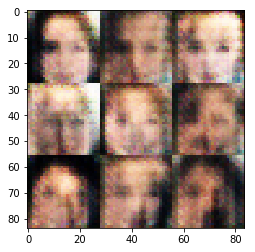

Epoch: 1/10 Discriminator Loss: 1.0266 Generator Loss: 1.6542
Epoch: 1/10 Discriminator Loss: 0.8086 Generator Loss: 1.7067
Epoch: 1/10 Discriminator Loss: 0.9340 Generator Loss: 1.5029
Epoch: 1/10 Discriminator Loss: 1.1748 Generator Loss: 0.7530
Epoch: 1/10 Discriminator Loss: 0.7845 Generator Loss: 1.7320


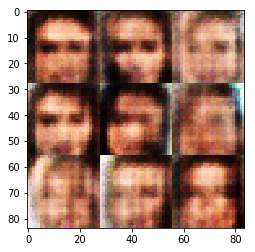

Epoch: 1/10 Discriminator Loss: 1.3155 Generator Loss: 0.5085
Epoch: 1/10 Discriminator Loss: 0.9964 Generator Loss: 1.1682
Epoch: 1/10 Discriminator Loss: 0.7896 Generator Loss: 1.5691
Epoch: 1/10 Discriminator Loss: 0.7098 Generator Loss: 1.4413
Epoch: 1/10 Discriminator Loss: 0.9310 Generator Loss: 1.0022


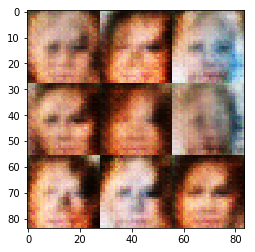

Epoch: 1/10 Discriminator Loss: 1.6428 Generator Loss: 3.5228
Epoch: 1/10 Discriminator Loss: 1.1543 Generator Loss: 1.3533
Epoch: 1/10 Discriminator Loss: 0.7678 Generator Loss: 1.3188
Epoch: 1/10 Discriminator Loss: 1.1337 Generator Loss: 1.2188
Epoch: 1/10 Discriminator Loss: 1.1088 Generator Loss: 0.9586


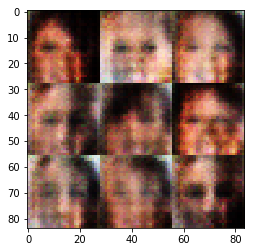

Epoch: 1/10 Discriminator Loss: 0.8206 Generator Loss: 2.0319
Epoch: 1/10 Discriminator Loss: 0.9240 Generator Loss: 1.9803
Epoch: 1/10 Discriminator Loss: 0.8113 Generator Loss: 1.6715
Epoch: 1/10 Discriminator Loss: 1.0332 Generator Loss: 1.5441
Epoch: 1/10 Discriminator Loss: 1.1075 Generator Loss: 2.5070


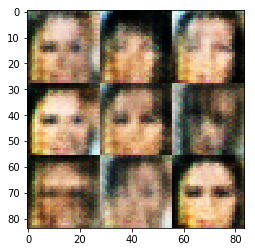

Epoch: 1/10 Discriminator Loss: 0.8972 Generator Loss: 1.2894
Epoch: 1/10 Discriminator Loss: 1.2726 Generator Loss: 0.9546
Epoch: 1/10 Discriminator Loss: 1.7891 Generator Loss: 0.3305
Epoch: 1/10 Discriminator Loss: 0.8564 Generator Loss: 1.4568
Epoch: 1/10 Discriminator Loss: 0.9401 Generator Loss: 1.3721


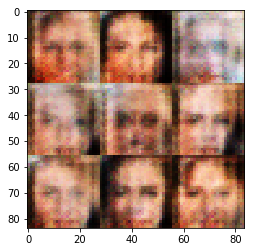

Epoch: 1/10 Discriminator Loss: 0.8557 Generator Loss: 1.1474
Epoch: 1/10 Discriminator Loss: 1.0834 Generator Loss: 2.1726
Epoch: 1/10 Discriminator Loss: 0.7980 Generator Loss: 1.4764
Epoch: 1/10 Discriminator Loss: 0.9372 Generator Loss: 1.1432
Epoch: 1/10 Discriminator Loss: 0.9538 Generator Loss: 2.4702


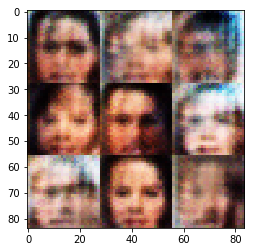

Epoch: 1/10 Discriminator Loss: 0.9310 Generator Loss: 1.3422
Epoch: 1/10 Discriminator Loss: 1.1412 Generator Loss: 1.0835
Epoch: 1/10 Discriminator Loss: 1.3916 Generator Loss: 2.3971
Epoch: 1/10 Discriminator Loss: 1.1182 Generator Loss: 1.0409
Epoch: 1/10 Discriminator Loss: 1.0517 Generator Loss: 1.3735


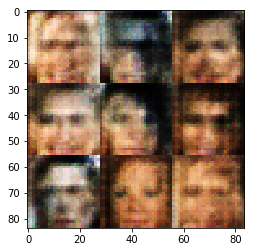

Epoch: 1/10 Discriminator Loss: 1.0473 Generator Loss: 1.0687
Epoch: 1/10 Discriminator Loss: 1.1031 Generator Loss: 0.8614
Epoch: 1/10 Discriminator Loss: 1.4374 Generator Loss: 0.5746
Epoch: 1/10 Discriminator Loss: 0.9167 Generator Loss: 1.5772
Epoch: 1/10 Discriminator Loss: 0.9179 Generator Loss: 0.9904


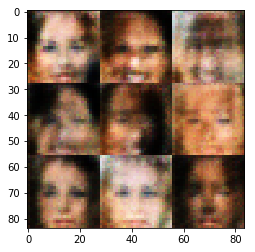

Epoch: 1/10 Discriminator Loss: 1.2254 Generator Loss: 0.9407
Epoch: 1/10 Discriminator Loss: 1.0742 Generator Loss: 1.5527
Epoch: 1/10 Discriminator Loss: 0.9608 Generator Loss: 1.1311
Epoch: 1/10 Discriminator Loss: 1.1307 Generator Loss: 0.8022
Epoch: 1/10 Discriminator Loss: 0.8773 Generator Loss: 1.5633


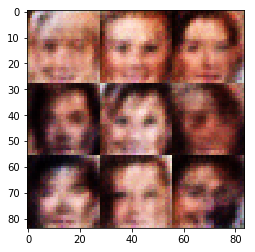

Epoch: 1/10 Discriminator Loss: 1.2486 Generator Loss: 1.0406
Epoch: 1/10 Discriminator Loss: 1.2134 Generator Loss: 0.5772
Epoch: 1/10 Discriminator Loss: 1.0972 Generator Loss: 0.9475
Epoch: 1/10 Discriminator Loss: 1.1265 Generator Loss: 0.7637
Epoch: 1/10 Discriminator Loss: 1.0409 Generator Loss: 1.3475


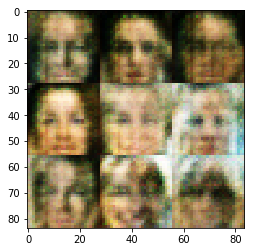

Epoch: 1/10 Discriminator Loss: 0.9624 Generator Loss: 1.0246
Epoch: 1/10 Discriminator Loss: 1.0760 Generator Loss: 1.1056
Epoch: 1/10 Discriminator Loss: 1.6835 Generator Loss: 0.9409
Epoch: 1/10 Discriminator Loss: 1.2583 Generator Loss: 0.7153
Epoch: 1/10 Discriminator Loss: 0.9577 Generator Loss: 1.5736


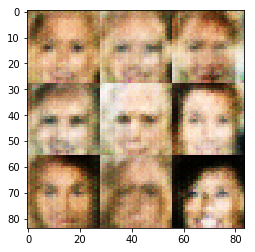

Epoch: 1/10 Discriminator Loss: 1.5996 Generator Loss: 0.9826
Epoch: 1/10 Discriminator Loss: 1.0081 Generator Loss: 1.1029
Epoch: 1/10 Discriminator Loss: 1.3770 Generator Loss: 0.9238
Epoch: 1/10 Discriminator Loss: 1.4088 Generator Loss: 0.7376
Epoch: 1/10 Discriminator Loss: 0.7588 Generator Loss: 1.2476


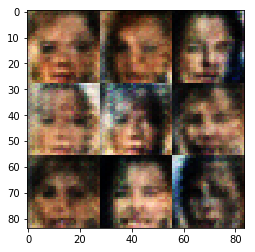

Epoch: 1/10 Discriminator Loss: 1.3372 Generator Loss: 1.2478
Epoch: 1/10 Discriminator Loss: 0.9689 Generator Loss: 1.0534
Epoch: 1/10 Discriminator Loss: 1.3092 Generator Loss: 0.9466
Epoch: 1/10 Discriminator Loss: 0.9343 Generator Loss: 1.1460
Epoch: 1/10 Discriminator Loss: 1.4521 Generator Loss: 0.6202


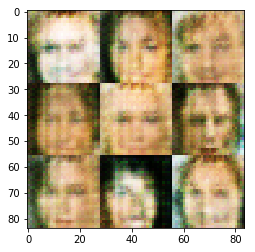

Epoch: 1/10 Discriminator Loss: 1.0763 Generator Loss: 1.1089
Epoch: 1/10 Discriminator Loss: 1.0302 Generator Loss: 1.2046
Epoch: 1/10 Discriminator Loss: 1.7077 Generator Loss: 0.5154
Epoch: 1/10 Discriminator Loss: 0.9454 Generator Loss: 1.2511
Epoch: 1/10 Discriminator Loss: 1.8041 Generator Loss: 0.4902


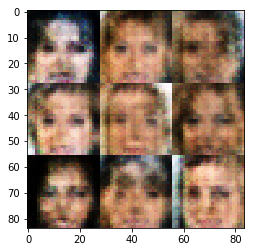

Epoch: 1/10 Discriminator Loss: 1.0057 Generator Loss: 1.0213
Epoch: 1/10 Discriminator Loss: 1.2639 Generator Loss: 0.8192
Epoch: 1/10 Discriminator Loss: 0.9586 Generator Loss: 1.1025
Epoch: 1/10 Discriminator Loss: 1.0501 Generator Loss: 1.0808
Epoch: 1/10 Discriminator Loss: 1.2570 Generator Loss: 1.0427


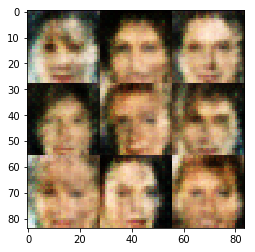

Epoch: 1/10 Discriminator Loss: 0.9382 Generator Loss: 1.1017
Epoch: 1/10 Discriminator Loss: 1.2579 Generator Loss: 1.1618
Epoch: 1/10 Discriminator Loss: 0.8304 Generator Loss: 1.2387
Epoch: 1/10 Discriminator Loss: 1.1442 Generator Loss: 1.1469
Epoch: 1/10 Discriminator Loss: 0.9115 Generator Loss: 1.0682


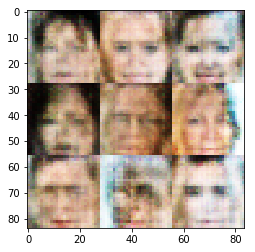

Epoch: 1/10 Discriminator Loss: 1.4927 Generator Loss: 0.7793
Epoch: 1/10 Discriminator Loss: 0.8245 Generator Loss: 1.3485
Epoch: 1/10 Discriminator Loss: 1.2030 Generator Loss: 1.0326
Epoch: 1/10 Discriminator Loss: 1.1654 Generator Loss: 0.9108
Epoch: 1/10 Discriminator Loss: 1.3024 Generator Loss: 0.8066


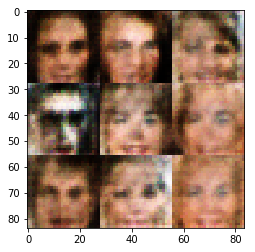

Epoch: 1/10 Discriminator Loss: 1.0446 Generator Loss: 0.9156
Epoch: 1/10 Discriminator Loss: 1.0836 Generator Loss: 1.0048
Epoch: 1/10 Discriminator Loss: 1.1306 Generator Loss: 0.8740
Epoch: 1/10 Discriminator Loss: 1.0586 Generator Loss: 0.9437
Epoch: 1/10 Discriminator Loss: 1.4295 Generator Loss: 1.0917


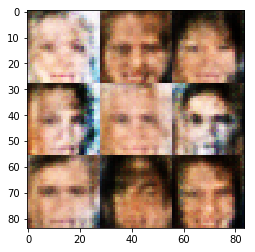

Epoch: 1/10 Discriminator Loss: 1.0230 Generator Loss: 1.0491
Epoch: 1/10 Discriminator Loss: 1.1216 Generator Loss: 0.9840
Epoch: 1/10 Discriminator Loss: 1.3096 Generator Loss: 0.5557
Epoch: 1/10 Discriminator Loss: 1.4107 Generator Loss: 0.6355
Epoch: 1/10 Discriminator Loss: 0.8751 Generator Loss: 1.2213


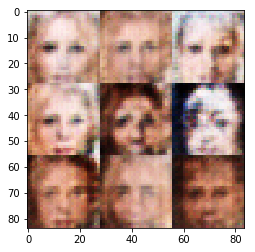

Epoch: 1/10 Discriminator Loss: 1.4536 Generator Loss: 0.8136
Epoch: 1/10 Discriminator Loss: 0.7031 Generator Loss: 1.3371
Epoch: 1/10 Discriminator Loss: 1.2834 Generator Loss: 0.9589
Epoch: 1/10 Discriminator Loss: 0.9326 Generator Loss: 1.0913
Epoch: 1/10 Discriminator Loss: 1.4344 Generator Loss: 0.8445


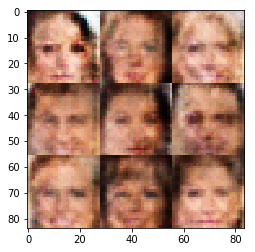

Epoch: 1/10 Discriminator Loss: 1.0366 Generator Loss: 0.9169
Epoch: 1/10 Discriminator Loss: 1.4812 Generator Loss: 0.8698
Epoch: 1/10 Discriminator Loss: 1.0606 Generator Loss: 0.9531
Epoch: 1/10 Discriminator Loss: 1.4361 Generator Loss: 1.1648
Epoch: 1/10 Discriminator Loss: 1.0892 Generator Loss: 1.5005


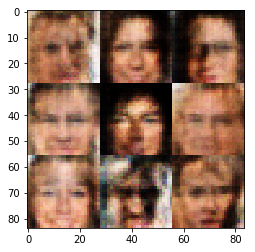

Epoch: 1/10 Discriminator Loss: 1.1879 Generator Loss: 0.8720
Epoch: 1/10 Discriminator Loss: 1.0214 Generator Loss: 1.0920
Epoch: 1/10 Discriminator Loss: 1.5300 Generator Loss: 1.0218
Epoch: 1/10 Discriminator Loss: 0.9232 Generator Loss: 1.1433
Epoch: 1/10 Discriminator Loss: 1.4207 Generator Loss: 0.6987


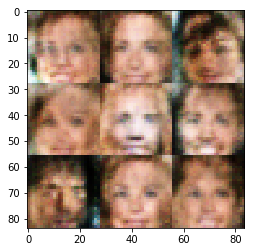

Epoch: 1/10 Discriminator Loss: 1.2249 Generator Loss: 1.0924
Epoch: 1/10 Discriminator Loss: 1.2367 Generator Loss: 0.8192
Epoch: 1/10 Discriminator Loss: 0.8549 Generator Loss: 1.1498
Epoch: 1/10 Discriminator Loss: 1.5222 Generator Loss: 0.7645
Epoch: 1/10 Discriminator Loss: 1.0465 Generator Loss: 0.7732


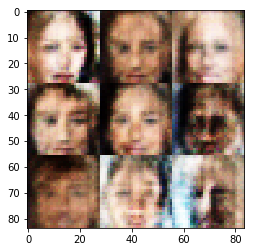

Epoch: 1/10 Discriminator Loss: 1.3724 Generator Loss: 0.7447
Epoch: 1/10 Discriminator Loss: 0.9453 Generator Loss: 1.4307
Epoch: 1/10 Discriminator Loss: 1.3417 Generator Loss: 0.6820
Epoch: 1/10 Discriminator Loss: 1.1230 Generator Loss: 1.1351
Epoch: 1/10 Discriminator Loss: 1.3508 Generator Loss: 0.9803


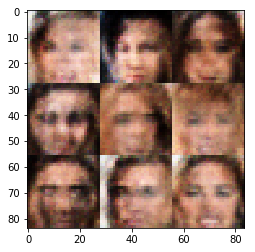

Epoch: 1/10 Discriminator Loss: 0.9401 Generator Loss: 0.9921
Epoch: 1/10 Discriminator Loss: 1.2781 Generator Loss: 0.8186
Epoch: 1/10 Discriminator Loss: 1.1567 Generator Loss: 0.9778
Epoch: 1/10 Discriminator Loss: 1.3702 Generator Loss: 0.6445
Epoch: 1/10 Discriminator Loss: 1.0003 Generator Loss: 1.0195


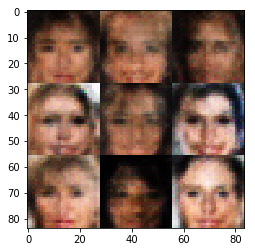

Epoch: 1/10 Discriminator Loss: 1.5191 Generator Loss: 0.8395
Epoch: 1/10 Discriminator Loss: 1.0779 Generator Loss: 0.9585
Epoch: 1/10 Discriminator Loss: 1.5784 Generator Loss: 0.7947
Epoch: 1/10 Discriminator Loss: 1.0414 Generator Loss: 0.9963
Epoch: 1/10 Discriminator Loss: 1.1646 Generator Loss: 0.9451


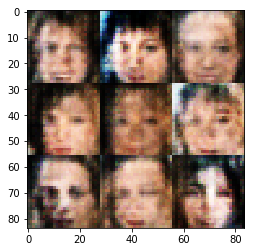

Epoch: 1/10 Discriminator Loss: 0.9374 Generator Loss: 1.2636
Epoch: 1/10 Discriminator Loss: 1.4035 Generator Loss: 0.7378
Epoch: 1/10 Discriminator Loss: 1.1287 Generator Loss: 0.9146
Epoch: 1/10 Discriminator Loss: 1.3952 Generator Loss: 0.9435
Epoch: 1/10 Discriminator Loss: 0.9759 Generator Loss: 1.1397


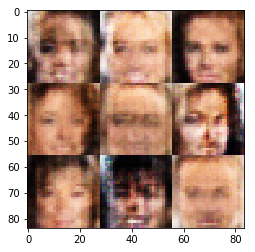

Epoch: 1/10 Discriminator Loss: 1.3952 Generator Loss: 0.7724
Epoch: 1/10 Discriminator Loss: 1.3636 Generator Loss: 0.7851
Epoch: 1/10 Discriminator Loss: 1.3782 Generator Loss: 0.7540
Epoch: 1/10 Discriminator Loss: 1.1215 Generator Loss: 1.0848
Epoch: 1/10 Discriminator Loss: 1.1662 Generator Loss: 0.8068


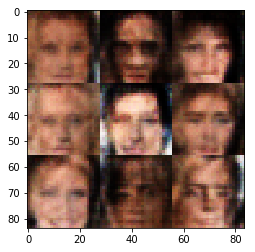

Epoch: 1/10 Discriminator Loss: 1.0931 Generator Loss: 1.0034
Epoch: 1/10 Discriminator Loss: 1.1906 Generator Loss: 0.8107
Epoch: 1/10 Discriminator Loss: 1.1937 Generator Loss: 0.8780
Epoch: 1/10 Discriminator Loss: 1.6399 Generator Loss: 0.6749
Epoch: 1/10 Discriminator Loss: 1.0906 Generator Loss: 0.6892


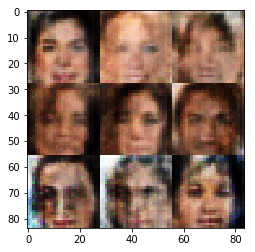

Epoch: 1/10 Discriminator Loss: 1.2128 Generator Loss: 0.8884
Epoch: 1/10 Discriminator Loss: 1.0510 Generator Loss: 1.2652
Epoch: 1/10 Discriminator Loss: 1.3633 Generator Loss: 0.7132
Epoch: 1/10 Discriminator Loss: 0.9971 Generator Loss: 1.1607
Epoch: 1/10 Discriminator Loss: 1.2352 Generator Loss: 0.8947


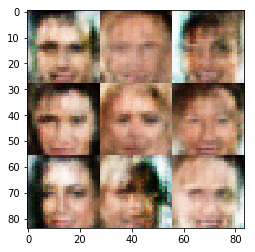

Epoch: 1/10 Discriminator Loss: 1.0223 Generator Loss: 1.0062
Epoch: 1/10 Discriminator Loss: 1.2220 Generator Loss: 1.1119
Epoch: 1/10 Discriminator Loss: 1.0530 Generator Loss: 1.0979
Epoch: 1/10 Discriminator Loss: 1.2157 Generator Loss: 1.0636
Epoch: 1/10 Discriminator Loss: 1.0898 Generator Loss: 1.1511


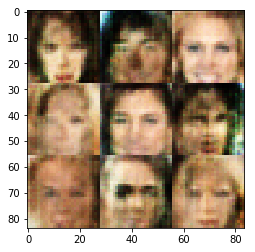

Epoch: 1/10 Discriminator Loss: 1.2871 Generator Loss: 0.6628
Epoch: 1/10 Discriminator Loss: 1.1793 Generator Loss: 0.7737
Epoch: 1/10 Discriminator Loss: 1.2423 Generator Loss: 0.7392
Epoch: 1/10 Discriminator Loss: 1.1690 Generator Loss: 0.7363
Epoch: 1/10 Discriminator Loss: 1.5606 Generator Loss: 0.4276


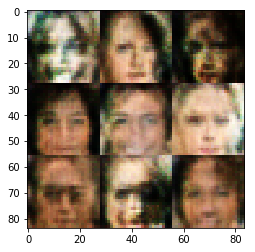

Epoch: 1/10 Discriminator Loss: 0.9431 Generator Loss: 1.0732
Epoch: 1/10 Discriminator Loss: 1.3397 Generator Loss: 0.8079
Epoch: 1/10 Discriminator Loss: 1.1217 Generator Loss: 0.8699
Epoch: 1/10 Discriminator Loss: 1.2268 Generator Loss: 0.7602
Epoch: 1/10 Discriminator Loss: 1.2314 Generator Loss: 1.1019


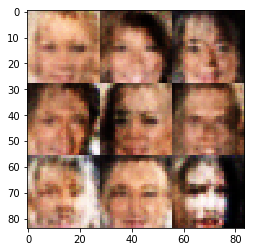

Epoch: 1/10 Discriminator Loss: 1.1263 Generator Loss: 0.9333
Epoch: 2/10 Discriminator Loss: 0.9670 Generator Loss: 1.2279
Epoch: 2/10 Discriminator Loss: 1.2406 Generator Loss: 0.8094
Epoch: 2/10 Discriminator Loss: 1.2162 Generator Loss: 1.0304
Epoch: 2/10 Discriminator Loss: 1.1111 Generator Loss: 0.8194


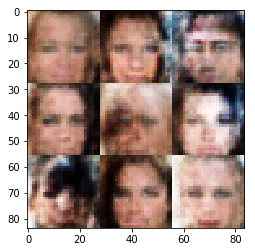

Epoch: 2/10 Discriminator Loss: 1.3181 Generator Loss: 0.8961
Epoch: 2/10 Discriminator Loss: 1.3017 Generator Loss: 0.8223
Epoch: 2/10 Discriminator Loss: 1.0263 Generator Loss: 1.1605
Epoch: 2/10 Discriminator Loss: 1.4454 Generator Loss: 0.4898
Epoch: 2/10 Discriminator Loss: 1.3009 Generator Loss: 0.5827


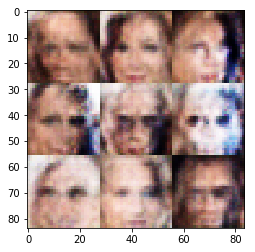

Epoch: 2/10 Discriminator Loss: 1.1996 Generator Loss: 0.6796


In [ ]:
batch_size = 128
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.